In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split # Split data into train data and test data
from sklearn.metrics import r2_score, mean_squared_error # Metrics for Regression Analysis
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("laptop-price-dataset-april-2024.csv")
df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,Lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10,14.0,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
1,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro",15.6,64,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
2,HP,"NEW HP 15 Laptop. 15.6"" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm",15.6,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,369.95
3,Lenovo,2024 Lenovo Ideapad Laptop 15 FHD Touch Intel i5 Upto 40GB RAM&2TB SSD Win 11Pro,15.6,Up,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,459.00
4,Lenovo,"2024 Lenovo Ideapad Laptop 15.6"" FHD Touch Intel i5 16GB RAM & 512GB Win 11 Pro",15.6,16,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,499.00


## 1. Data Understanding

In [5]:
df.shape

(2952, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2952 non-null   object 
 1   Product_Description  2952 non-null   object 
 2   Screen_Size          2952 non-null   float64
 3   RAM                  2952 non-null   object 
 4   Processor            2952 non-null   object 
 5   GPU                  2604 non-null   object 
 6   GPU_Type             2718 non-null   object 
 7   Resolution           2565 non-null   object 
 8   Condition            2952 non-null   object 
 9   Price                2952 non-null   float64
dtypes: float64(2), object(8)
memory usage: 230.8+ KB


In [7]:
df.describe()

,Screen_Size,Price
count,2952.000000,2952.000000
mean,14.550237,517.552805
std,1.175322,235.592872
min,10.000000,0.000000
25%,14.000000,325.990000
50%,14.000000,489.990000
75%,15.600000,699.000000
max,18.000000,999.990000


In [8]:
df.isnull().sum().sort_values(ascending=False)

Resolution             387
GPU                    348
GPU_Type               234
Brand                    0
Product_Description      0
Screen_Size              0
RAM                      0
Processor                0
Condition                0
Price                    0
dtype: int64

In [9]:
df.nunique()

Brand                    25
Product_Description    2952
Screen_Size              28
RAM                      23
Processor                48
GPU                     220
GPU_Type                  8
Resolution               54
Condition                 5
Price                  1119
dtype: int64

### Summary of Data Understanding
- Data contains 2952 rows and 10 columns
- In order to predict laptop price, the 'Price' column will be a dependent variable
- Data are distributed into 2 numerical columns and 8 categorical columns
- Average laptop price is \$517.55 and standard deviation is \$235.59 which is high variability
- Average laptop screen size is 14.55 and standard deviation is 1.17 so data spreads narrowly
- Resolution,GPU,and GPU_Type columns have some missing values
- "Product_description" column represented every entity, but in this column we have some information about storage.

## 2. Data Preprocessing

First, let's check unique values in the dataset

In [10]:
dfp = df.copy()

In [11]:
cat_cols = dfp.select_dtypes(include='object').columns
cat_cols

Index(['Brand', 'Product_Description', 'RAM', 'Processor', 'GPU', 'GPU_Type',
       'Resolution', 'Condition'],
      dtype='object')

In [12]:
def unique_vals(col):
    print(f"Details of the column {col} is: \n {dfp[col].unique()}")
    print("-"*100)

In [13]:
for col in cat_cols:
    unique_vals(col)

Details of the column Brand is: 
 ['Lenovo' 'Dell' 'HP' 'Microsoft' 'Asus' 'Razer' 'MSI' 'Apple' 'Panasonic'
 'LG' 'Samsung' 'Acer' 'Gateway' 'Huawei' 'Getac' 'Google' 'Dell Inc.'
 'Chuwi' 'Sony' 'ByteSpeed' 'Eurocom' 'Gigabyte' 'AVITA' 'Intel' 'Ruggon']
----------------------------------------------------------------------------------------------------
Details of the column Product_Description is: 
 ['Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10'
 'Dell Latitude 15.6" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro'
 'NEW HP 15 Laptop. 15.6" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm'
 ...
 'Dell Precision 5550 Workstation 15 15.6 Laptop Core i7 4k uhd Touchscreen F'
 'HP 15 Laptop 15.6" FHD i5-1135G7 8GB RAM 256GB SSD Win 11 -15-dy2795wm'
 '3 PCS Karlash 6 Column Undated Appointment Book – Six Person Daily and Hourly...']
----------------------------------------------------------------------------------------------------
Det

In the "Resolution" and "GPU_Type" columns, missing values ​​can be replaced with the most frequently occurring values. Meanwhile, for the "GPU" column, it is decided to transform it first before replacing missing values due to the large number of unique values.

In [14]:
imputer = SimpleImputer(strategy='most_frequent').set_output(transform="pandas")
dfp[["Resolution","GPU_Type"]] = imputer.fit_transform(dfp[["Resolution","GPU_Type"]])

In the RAM column, we have some mismatched values where some end in "GB" and some don't and some error values like "Up", "up", and "upto". Additionally, this column is of type "object" so it needs to be fixed.

In [15]:
def extract_numbers(text):
    nums = re.findall(r'\d+(?:\.\d+)?', text)  # Regular expression to find numbers
    if nums:
        return int(nums[0])  # Return the first number as a float
    else:
        return None  # Return None if no number is found

In [16]:
# Apply the function to each element in the DataFrame
dfp["RAM"] = dfp[["RAM"]].map(extract_numbers)

In [17]:
# Group GPU type into two groups
dfp["GPU_Type"] = dfp["GPU_Type"].apply(lambda x: "Integrated/On-Board Graphics" if x != "Dedicated Graphics" else x)

The "Resolution" column shows inconsistent values. Some values that should be in (Width)x(Height) format are instead in a mix of text and numbers. Some values are even just text. Let's make it consistent

In [18]:
# Convert resolution format to (width)x(height)"
dfp["Resolution"] = dfp["Resolution"].str.replace("5K","5120x2880")
dfp["Resolution"] = dfp["Resolution"].str.replace("FHD","1920x1080")
dfp["Resolution"] = dfp["Resolution"].str.replace("1080p","1920x1080")
# Divide Resolution into two columns
resolution_df = dfp["Resolution"].str.split("x|X",n=1,expand=True)
dfp["Resolution_Width"] = resolution_df[0]
dfp["Resolution_Height"] = resolution_df[1]
dfp["Resolution_Width"] = dfp["Resolution_Width"].str.findall("\d{4}").apply(lambda x: int(x[0]) if len(x) != 0 else None)
dfp["Resolution_Height"] = dfp["Resolution_Height"].str.findall("\d.[0-9]*").apply(lambda x: None if x == None or x == [] else int(x[0]))

In [19]:
# Take first 3 words from Processor series
dfp["Processor"] = dfp["Processor"].apply(lambda x : " ".join(x.split(" ")[:3]))
dfp["Processor"].unique(), dfp["Processor"].nunique()

(array(['Intel Core i5', 'Intel Core i7', 'Intel Core i3', 'Intel Core i9',
        'AMD Ryzen 5', 'AMD Ryzen 9', 'AMD Ryzen 7', 'AMD Ryzen 3'],
       dtype=object),
 8)

In [20]:
def GPUPreprocess(text):
    """
    Preprocess text of GPU specification into more general term and clustered item.
    """
    text = str(text)
    text = text.lower()  # Convert to lowercase for case-insensitive comparison

    # Using regular expressions for more efficient and flexible matching
    if re.search(r'intel hd', text):
        return 'Intel HD'
    elif re.search(r'intel iris', text):
        return 'Intel Iris'
    elif re.search(r'nvidia geforce|nvidia gtx', text):
        return 'NVIDIA GeForce'
    elif re.search(r'nvidia quadro|nvidia t1200', text):
        return 'NVIDIA Quadro'
    elif re.search(r'intel uhd', text):
        return 'Intel UHD'
    elif re.search(r'radeon', text):
        return 'AMD Radeon'
    elif 'intel' in text or 'i5-8250u' in text:
        return 'Other Intel'
    else:
        return 'Other GPU'

In [21]:
dfp["GPU"] = dfp["GPU"].apply(GPUPreprocess)

In [22]:
dfp["GPU"].unique()

array(['Intel HD', 'Intel UHD', 'Intel Iris', 'NVIDIA Quadro',
       'NVIDIA GeForce', 'Other GPU', 'AMD Radeon', 'Other Intel'],
      dtype=object)

In [23]:
def extract_storage(text):
    """
    Extract information about storage capacity from product description.
    """
    SSD_pattern = r"(\d+\.?\d*)\s*(TB|GB)\s*(SSD)"
    HDD_pattern = r"(\d+\.?\d*)\s*(TB|GB)\s*(HDD)"
    return re.findall(SSD_pattern, text), re.findall(HDD_pattern, text)

In [24]:
# Making of storage column from product description column
storage_df = dfp["Product_Description"].apply(extract_storage)
dfp["SSD"] = storage_df.apply(lambda x: " ".join(x[0][0]) if x[0] != [] else '0')
dfp["HDD"] = storage_df.apply(lambda x: " ".join(x[1][0]) if x[1] != [] else '0')
dfp["SSD"] = dfp["SSD"].str.replace("TB","000 GB").str.findall("\d").apply(lambda x: "".join(x)).astype("int64")
dfp["HDD"] = dfp["HDD"].str.replace("TB","000 GB").str.findall("\d").apply(lambda x: "".join(x)).astype("int64")
dfp["SSD"].unique(), dfp["HDD"].unique()

(array([  256,  2000,     0,   512,  1000,   238,   128,   240,    16,
           64,   120,   255,   500,   250,   480,   800,   180,  4000,
        15000,     4], dtype=int64),
 array([   0, 1000,  256,  500,  512, 2000], dtype=int64))

In [25]:
# There is a suspicious value, let's check it
dfp.loc[(dfp["SSD"] == 15000)]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
1594,Asus,"ASUS Vivobook 15.6"" Touchscreen Intel 11th Gen i3 8GB 256G X515EA-212.V15TB SSD",15.6,8.0,Intel Core i3,Intel HD,Integrated/On-Board Graphics,1920 x 1080,New,375.0,1920.0,1080.0,15000,0


In [26]:
# Based on product description, we know that SSD size should be 256 GB
dfp["SSD"] = dfp["SSD"].replace(15000,256)

We have corrected the data format for several columns. Furthermore, some formatted columns will have empty data. Therefore, we will perform imputation with the appropriate method.

In [27]:
dfp.isnull().sum()

Brand                  0
Product_Description    0
Screen_Size            0
RAM                    5
Processor              0
GPU                    0
GPU_Type               0
Resolution             0
Condition              0
Price                  0
Resolution_Width       5
Resolution_Height      5
SSD                    0
HDD                    0
dtype: int64

In [28]:
# First let's check RAM
dfp.loc[dfp["RAM"].isnull()]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
3,Lenovo,2024 Lenovo Ideapad Laptop 15 FHD Touch Intel i5 Upto 40GB RAM&2TB SSD Win 11Pro,15.6,NaN,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,459.0,1920.0,1080.0,2000,0
1025,HP,"*NEW* HP 15.6"" Full HD Laptop - Intel Core i7 - Custom upto 64GB RAM & 4TB SSD",15.6,NaN,Intel Core i7,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,599.0,1920.0,1080.0,4000,0
1647,Asus,"Asus VivoBook 15 F512JA 15.6"" FHD Intel i3-1005G1 UP TO 20GB / 512GB SSD Win10 S",15.6,NaN,Intel Core i3,Intel UHD,Integrated/On-Board Graphics,1920 x 1080,New,419.0,1920.0,1080.0,512,0
1689,Dell,"2020 Dell 15.6"" TouchScreen Laptop i3-8145U ( i5-7200U),3.9GHz,16GB RAM &1TB SSD",15.6,NaN,Intel Core i3,Other GPU,Integrated/On-Board Graphics,1366 x 768,New,679.0,1366.0,768.0,1000,0
1808,HP,"NEW HP 17.3"" 13th GEN Intel i5 Custom upto 64GB & 2TB SSD FHD 1080P Backlit Key",17.3,NaN,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,649.0,1920.0,1080.0,2000,0


In [29]:
# Then check Resolution
dfp.loc[(dfp["Resolution_Width"].isnull()) | (dfp["Resolution_Height"].isnull())]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
249,HP,"HP ZBook Power G9 15.6 Intel i7-12800H, Nvidia RTX A1000, 16GB DDR5, 512GB SSD",15.6,16.0,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,15.6,Excellent - Refurbished,869.95,NaN,NaN,512,0
689,HP,"HP ZBook Power G10 15.6 Intel i7-13700H, Nvidia RTX A1000, 16GB DDR5, 512GB SSD",15.6,16.0,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,15.6,Excellent - Refurbished,999.95,NaN,NaN,512,0
822,Dell,Dell LATITUDE 5400 CHROME 14 Touch I5-8365U 128GB SSD 4GB W10 Backlit Keyboard,14.0,4.0,Intel Core i5,Other Intel,Integrated/On-Board Graphics,Not Included,Good - Refurbished,148.99,NaN,NaN,128,0
1251,Dell,Alienware 13-R1 Gaming Laptop 24 HOUR SALE!,13.0,16.0,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,Touchscreen,Open box,829.99,NaN,NaN,0,0
1257,Lenovo,"LENOVO X1 NANO GEN 1 13"" Touch I7-1180G7 1TB SSD 16GB W11P Backlit FP Reader",13.0,16.0,Intel Core i7,Other Intel,Integrated/On-Board Graphics,Not Included,Very Good - Refurbished,881.99,NaN,NaN,1000,0


In [30]:
# Apart from that, we also know that when formatting SSD and HDD data, there are empty values in both columns. 
# These are actually also missing values
dfp.loc[(dfp["SSD"] == 0) & (dfp['HDD'] == 0), ["SSD", "HDD"]] = [np.nan, np.nan]

In [31]:
dfp.isnull().sum()

Brand                     0
Product_Description       0
Screen_Size               0
RAM                       5
Processor                 0
GPU                       0
GPU_Type                  0
Resolution                0
Condition                 0
Price                     0
Resolution_Width          5
Resolution_Height         5
SSD                    1154
HDD                    1154
dtype: int64

Based on the results above, we have a lot of missing values. Performing imputation using univariate methods such as median or mean will reduce data variability. Even though the data is in the form of number, in essence, this data is actually ordinal data. Recommending to use the most frequently occurring value is also not a good idea, as it would strengthen the mayor's class position. Therefore, in this case, the k-Nearest Neighbor algorithm is used to fill in the missing values.

In [32]:
num_cols = dfp.select_dtypes(include=["float","int"]).columns
imputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")
dfp[num_cols] = imputer.fit_transform(dfp[num_cols])

In [33]:
dfp.isnull().sum()

Brand                  0
Product_Description    0
Screen_Size            0
RAM                    0
Processor              0
GPU                    0
GPU_Type               0
Resolution             0
Condition              0
Price                  0
Resolution_Width       0
Resolution_Height      0
SSD                    0
HDD                    0
dtype: int64

In [34]:
dfp.drop(["Product_Description","Resolution"],axis=1,inplace=True)

### Summary of Data Preprocessing
- Succesfully convert "RAM" from string data type into integer data type.
- Succesfully split "Resolution" into "Width" and "Height".
- Succesfully parse string in "GPU" so that number of unique values decreased.
- Succesfully create "SSD" and "HDD" columns from parsing "Product_Description" column
- Succesfully impute missing values with kNN imputer for "RAM", "Resolution"(width x height), and "Storage"(SSD and HDD) column

## 3. Exploratory Data Analysis

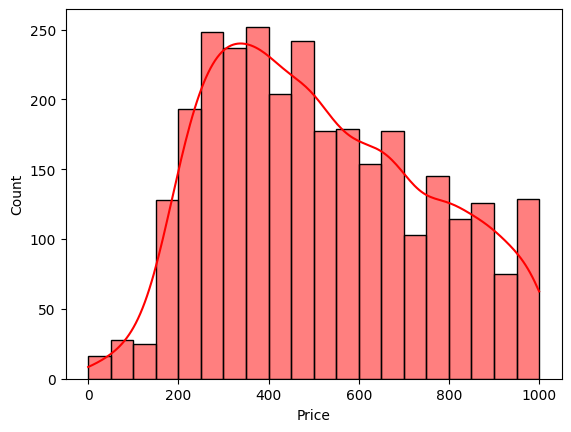

In [35]:
sns.histplot(df["Price"],kde=True,color='red')
plt.show()

- Most prices are concentrated in the \$200 to \$400 range. This indicates that many laptops are sold in that price range. 
- Products priced below \$200 may be aimed at price-sensitive consumers, while products priced above \$400 may be aimed at more premium consumers.

In [36]:
def countplot(col):
    plt.figure(figsize=(5,4))
    sns.countplot(data=dfp, x=col, palette="bright")
    plt.xticks(rotation=90)

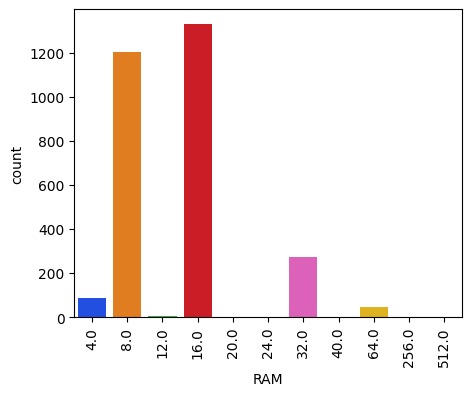

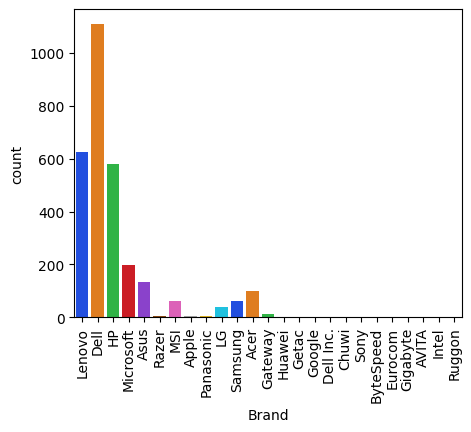

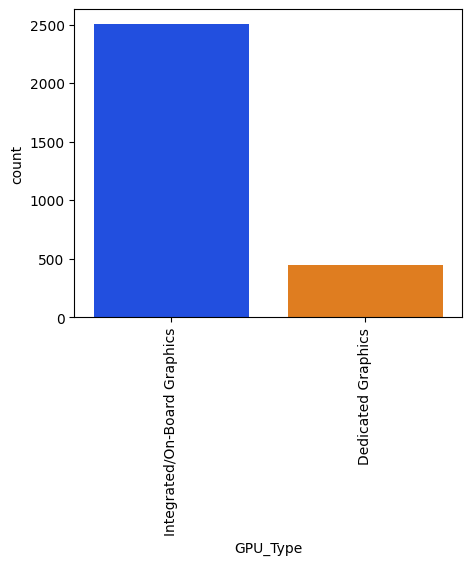

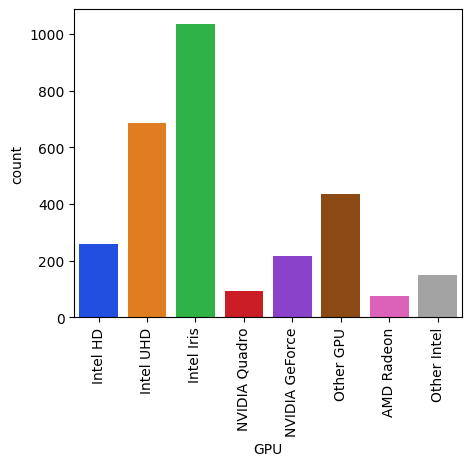

In [37]:
for col in ["RAM","Brand","GPU_Type","GPU"]:
    countplot(col)

- **8GB** and **16GB** RAM laptops dominated the market. Laptops with **4GB** and **8GB** of RAM may be more aimed at general users or students who have lighter computing needs. Meanwhile, laptops with **16GB**, **32GB**, or even higher RAM may be more aimed at professional users or gamers who need high performance. There is a need to offer more choices of laptops with **16GB** or **32GB** RAM capacity at competitive prices due to the large number of laptops with this capacity on the market.
- **Lenovo** and **Dell** laptops dominated the market. In the middle-class market, there are **HP**, **Asus**, and **Microsoft**. The amount of data available for minor brands is less, which can affect the accuracy of the regression model. Grouping minor brands into a single category “Other” can help reduce noise in the data and improve the stability of the model.
- GPU Type plot shows the existence of two distinct market segments: **integrated graphics** that prioritize cost efficiency and portability and are therefore more numerous on the market and **dedicated graphics** that require high graphics performance and are therefore less numerous on the market.
- **Intel** is the most widely used GPU manufacturer in laptops. **NVIDIA** follows with **NVIDIA Quadro** and **NVIDIA GeForce** for the flagship laptop market share.

In [38]:
def barplot(col):
    sns.barplot(data=dfp, x=col, y="Price", palette="bright")
    plt.xticks(rotation=90)
    plt.show()

In [39]:
cat_cols = dfp.select_dtypes(include="object").columns
num_cols = dfp.select_dtypes(include=["int","float"]).columns

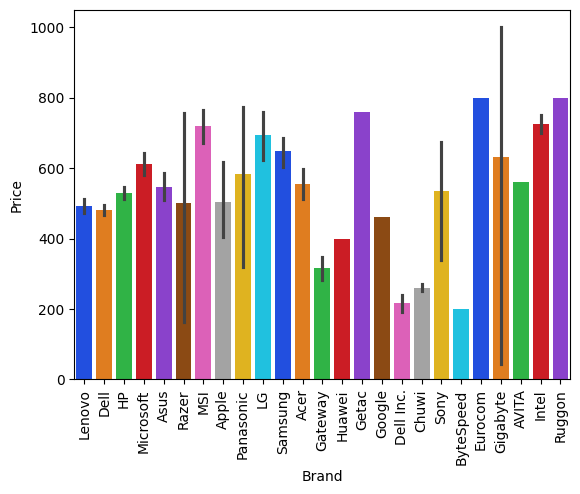

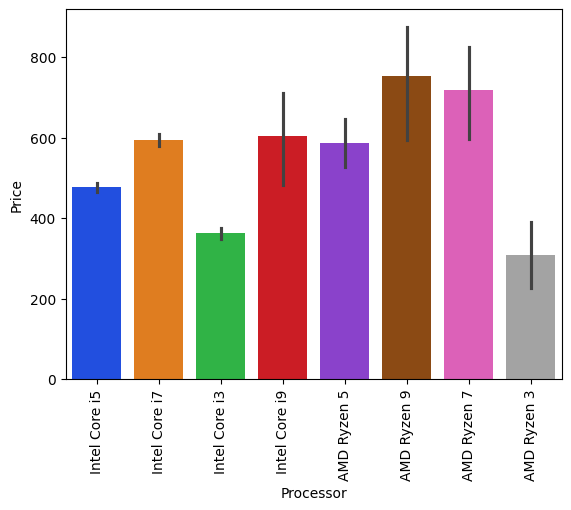

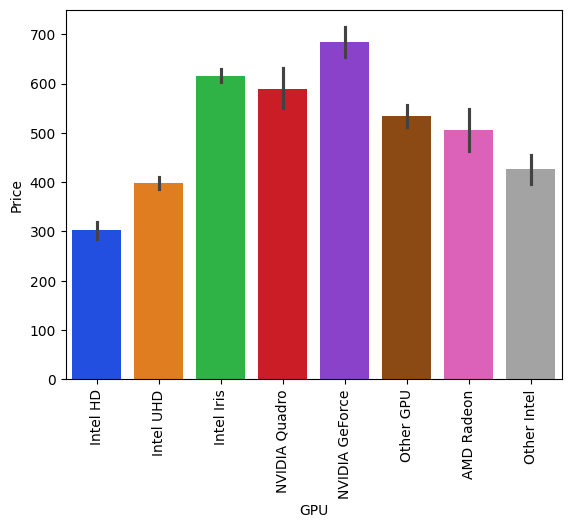

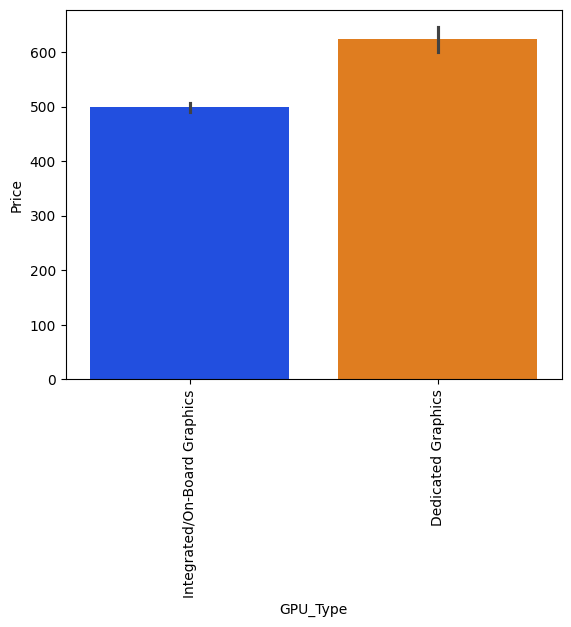

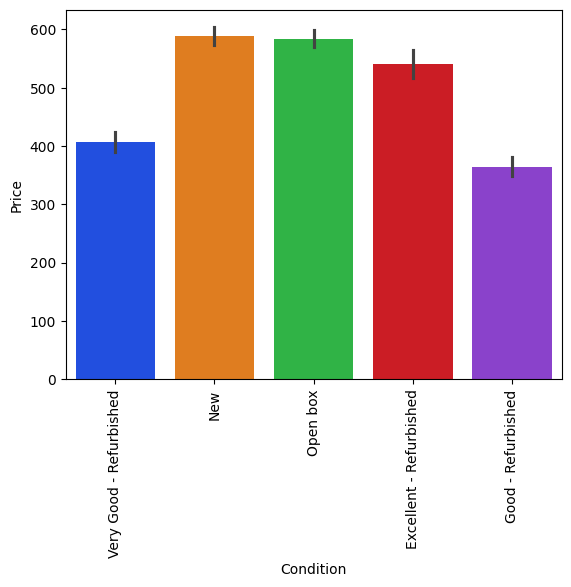

In [40]:
for col in cat_cols:
    barplot(col)

- Lenovo, Dell, HP, Microsoft, and ASUS have competitive prices and have small price variability indicating that these brands already have their respective target markets. Razer, Apple, Panasonic, Gigabyte, and Sony have large price variability indicating that there are products from various segments ranging from entry-level to high-end. Brands such as Ruggon and Apple show high prices with large variations, which may indicate products that focus on high performance or special features.
- For processors at a lower average price point, the Intel Core i3 and AMD Ryzen 3 are the most economical choices. For mid-range processors, the Intel Core i5, Intel Core i7, AMD Ryzen 5, and AMD Ryzen 7 offer a competitive price range. At the high end, the Intel Core i9 and AMD Ryzen 9 show higher prices with greater variation, indicating that they offer premium performance.
- Due to the larger market share and lower performance, laptops with Integrated Graphics have an average more affordable price. Dedicated Graphics offer premium performance but have a higher price.
- Laptop condition seems make sense as the price gradually decrease from New Laptops to Refurbished Laptops.

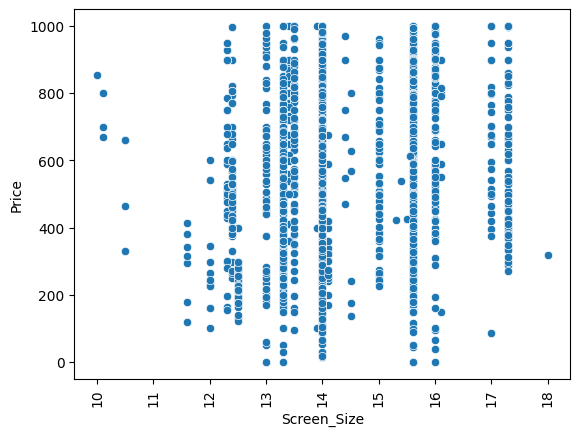

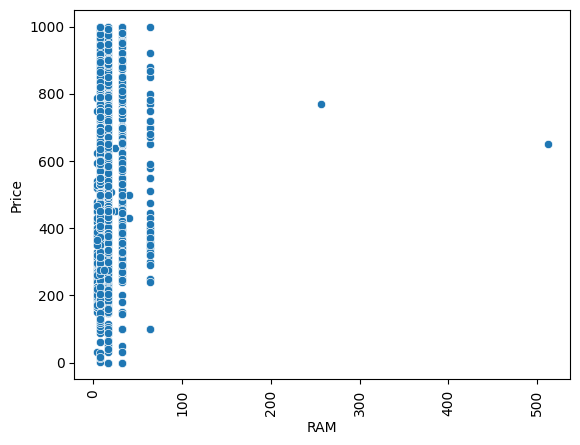

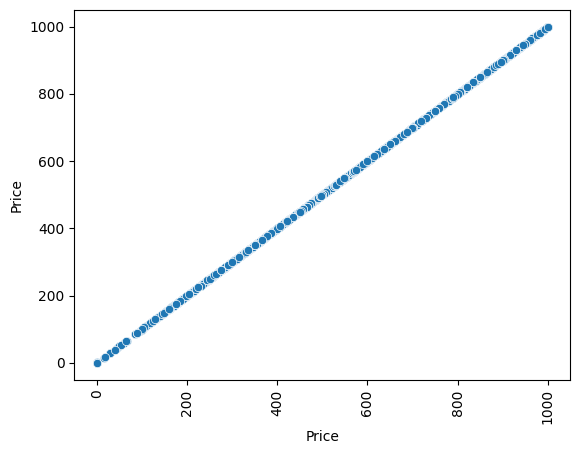

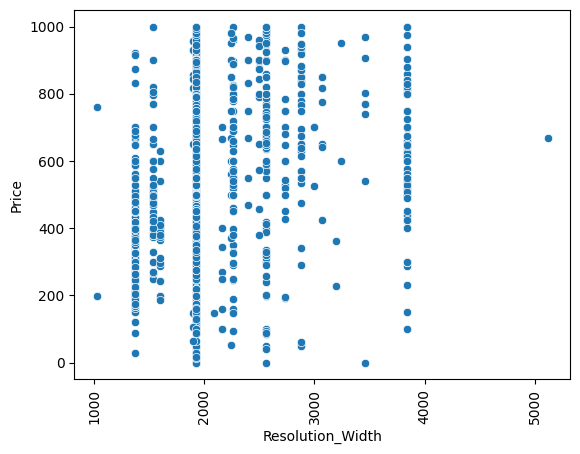

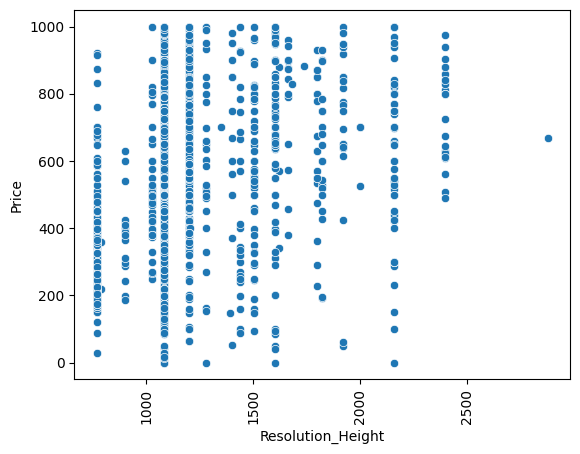

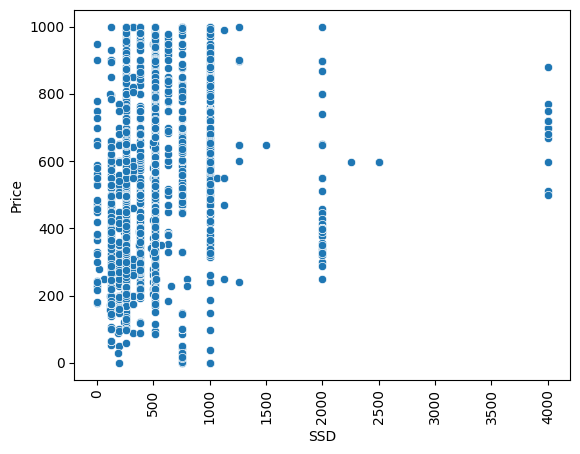

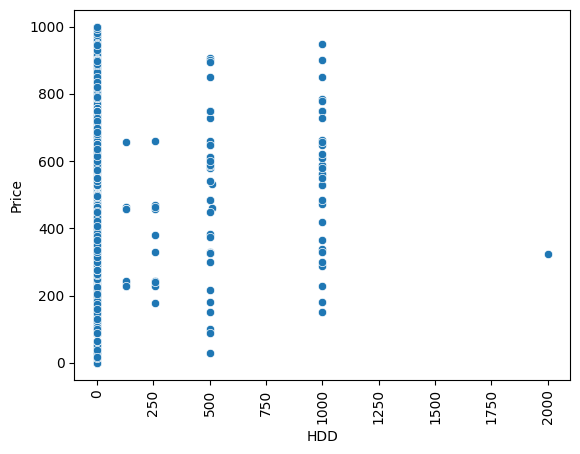

In [41]:
def scatterplot(col):
    sns.scatterplot(data=dfp, x=col, y="Price", palette="bright")
    plt.xticks(rotation=90)
    plt.show()
for col in num_cols:
    scatterplot(col)

It can be seen that the price has a very high variability so that no single feature is sufficient to provide a pattern of relationship with the price of the laptop. This also shows that the price of the laptop does not affect a small number of dominant features. Each feature is interconnected with other features to form the price.

In [42]:
# Calculated number of brand occurence in "Brand" column
brand_counts = dfp['Brand'].value_counts()

# Filter brands with frequency less than 50
less_50_brand = brand_counts[brand_counts < 50].index.tolist()

# Convert those brand into "Other" 
dfp["Brand"] = np.where(dfp['Brand'].isin(less_50_brand), 'Other', dfp['Brand'])
dfp["Brand"].value_counts()

Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Acer          100
Other          84
MSI            62
Samsung        61
Name: count, dtype: int64

<Axes: >

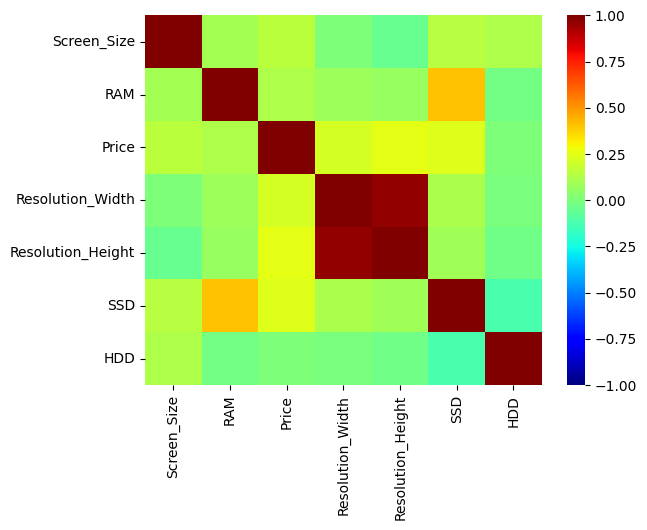

In [43]:
sns.heatmap(dfp[num_cols].corr(),cmap="jet",vmin=-1)

In [44]:
dfp[num_cols].corr()["Price"].sort_values(ascending=False)

Price                1.000000
Resolution_Height    0.251439
SSD                  0.240263
Resolution_Width     0.214688
Screen_Size          0.155904
RAM                  0.118995
HDD                  0.003871
Name: Price, dtype: float64

All of the features have low correlation to the price of laptop. Feature transformation and feature creation may be require so that the new fabricated feature have high correlation to the price. As we know that from correlation heatmap, "Resolution Width" and "Resolution Height" have high correlation each other then this lead to multicollinearity. In this case, we would transform these into PPI (Pixel per Inch) as we have "Screen_Size" column.

$ PPI = \frac{\sqrt{{reswidth}^2 + {resheight}^2}}{screensize} $

## 4. Feature Engineering

In [45]:
dfp["PPI"] = np.sqrt(dfp["Resolution_Width"]**2 + dfp["Resolution_Height"]**2)/dfp["Screen_Size"]
dfp.drop(["Resolution_Width","Resolution_Height","Screen_Size"],axis=1,inplace=True)

#### Encoding

In [46]:
dfp["Condition"].unique()

array(['Very Good - Refurbished', 'New', 'Open box',
       'Excellent - Refurbished', 'Good - Refurbished'], dtype=object)

In [47]:
ordinal_enc = OrdinalEncoder(categories=[[
    'New', 'Open box', 'Excellent - Refurbished',
    'Very Good - Refurbished', 'Good - Refurbished'
    ]]).set_output(transform="pandas")
condition_df = ordinal_enc.fit_transform(np.array(dfp["Condition"]).reshape(-1,1)).reset_index(drop=True)
df_encoded = pd.concat([dfp.select_dtypes(include="object").reset_index(drop=True), condition_df], axis=1)
df_encoded.drop("Condition",axis=1,inplace=True)
df_encoded = df_encoded.rename(columns={"x0":"Condition"})

In [48]:
onehot_df = df_encoded.select_dtypes(include="object").reset_index(drop=True)
encoder = OneHotEncoder()
onehot_encoded_df = encoder.fit_transform(onehot_df)
df_encoded = pd.concat([df_encoded, pd.DataFrame(onehot_encoded_df.toarray(), columns=encoder.get_feature_names_out())], axis=1)
df_encoded.drop(df_encoded.select_dtypes(include="object").columns,axis=1,inplace=True)

In [49]:
df_final = pd.concat([dfp.select_dtypes(include=["int","float"]).reset_index(drop=True),df_encoded],axis=1)

#### Train Test Split

In [50]:
y = df_final["Price"]
X = df_final.drop("Price",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 5. Model Development

In [51]:
# Linear Regression
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
r2_LR = r2_score(y_test, y_pred) 
rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression")
print(f"R-squared : {r2_LR}\nRMSE\t : {rmse_LR}")

Linear Regression
R-squared : 0.39663927011701483
RMSE	 : 178.5716069301259


In [52]:
# Lasso Regression
LS = Lasso()
LS.fit(X_train,y_train)
y_pred = LS.predict(X_test)
r2_lasso = r2_score(y_test, y_pred) 
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print("Lasso Regression")
print(f"R-squared : {r2_lasso}\nRMSE\t : {rmse_lasso}")

Lasso Regression
R-squared : 0.39138419092115506
RMSE	 : 179.34757181479497


In [53]:
# Suppor Vector Regression
svr = SVR(C=100, degree=4, gamma="auto")
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
r2_svr = r2_score(y_test, y_pred) 
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Support Vector Machine")
print(f"R-squared : {r2_svr}\nRMSE\t : {rmse_svr}")

Support Vector Machine
R-squared : 0.3458446341233886
RMSE	 : 185.93636682205664


In [54]:
# Random Forest Regression
forest = RandomForestRegressor( n_estimators=96, max_depth=19, 
                                max_features="log2", min_samples_leaf=2,
                                min_samples_split=8, bootstrap=False,
                                random_state=42)
forest.fit(X_train,y_train) # Train the model
y_pred = forest.predict(X_test) # Predict the dependent variable using trained model
r2_forest = r2_score(y_test, y_pred) # Evaluate the model
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred)) # Evaluate the model
print("Random Forest Regression")
print(f"R-squared : {r2_forest}\nRMSE\t : {rmse_forest}")

Random Forest Regression
R-squared : 0.4990569308446202
RMSE	 : 162.7114340343858


In [55]:
# XGBoost Regression
xgboost = XGBRegressor(n_estimators=120, max_depth=5)
xgboost.fit(X_train,y_train)
y_pred = xgboost.predict(X_test)
r2_xgboost = r2_score(y_test, y_pred) 
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost Regression")
print(f"R-squared : {r2_xgboost}\nRMSE\t : {rmse_xgboost}")

XGBoost Regression
R-squared : 0.4827723348641748
RMSE	 : 165.33498472842993


In [56]:
r2 = {
    "Linear" : float("{:.4f}".format(r2_LR)), 
    "SVM": float("{:.4f}".format(r2_LR)),
    "Random Forest" : float("{:.4f}".format(r2_forest)),
    "XGBoost" : float("{:.4f}".format(r2_xgboost))
      }

rmse = {
    "Linear" : float("{:.4f}".format(rmse_LR)), 
    "SVM": float("{:.4f}".format(rmse_LR)),
    "Random Forest" : float("{:.4f}".format(rmse_forest)),
    "XGBoost" : float("{:.4f}".format(rmse_xgboost))
      }

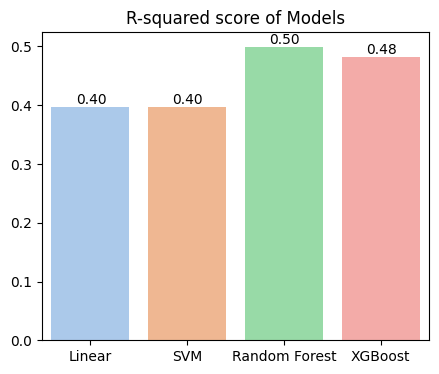

In [65]:
plt.figure(figsize=(5,4))
sns.barplot(data=r2, palette="pastel")
plt.title("R-squared score of Models")
for p in plt.gca().patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005))

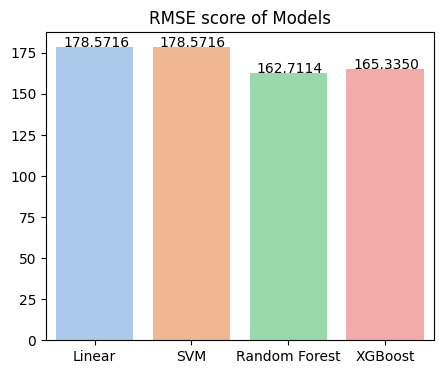

In [58]:
plt.figure(figsize=(5,4))
sns.barplot(data=rmse, palette="pastel")
plt.title("RMSE score of Models")
for p in plt.gca().patches:
    plt.annotate('{:.4f}'.format(p.get_height()), (p.get_x()+0.075, p.get_height()+0.005))

In [59]:
# Feature Importance
feature_names = X.columns
importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(10)

,Feature,Importance
4,Condition,0.220589
1,SSD,0.162364
3,PPI,0.101235
0,RAM,0.065704
24,GPU_Intel Iris,0.062075
25,GPU_Intel UHD,0.053456
23,GPU_Intel HD,0.051322
20,Processor_Intel Core i7,0.037646
18,Processor_Intel Core i3,0.033596
7,Brand_Dell,0.024704


Random Forest is the most effective model in predicting data with the best performance among the models compared. This model can explain 50% of the variability in laptop prices. The RMSE value of 162.57 indicates that, on average, your laptop price prediction is off by about \$162.57 from the actual price. This value is still quite large for laptop prices ranging from hundreds of dollars, so this model still needs to be improved. The price of a laptop is greatly influenced by several features such as condition, SSD, PPI and RAM.

## 6. Model Deployment

In [60]:
categorical_features = list(set(dfp.select_dtypes(include="object").columns)-set(["Condition"]))
ordinal_features = ["Condition"]
numeric_features = dfp.select_dtypes(include=["int","float"])

ordinal_encoder = OrdinalEncoder(categories=[[
    'New', 'Open box', 'Excellent - Refurbished',
    'Very Good - Refurbished', 'Good - Refurbished'
]])
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, categorical_features),
        ('ordinal', ordinal_encoder, ordinal_features)
    ],
    remainder='passthrough'  # 'passthrough' keeps the rest of the columns (numeric ones)
)

# Main Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=96, max_depth=19, 
                                max_features="log2", min_samples_leaf=2,
                                min_samples_split=8, bootstrap=False,
                                random_state=42))
])

In [61]:
X = dfp.drop("Price", axis=1)
y = dfp["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("R-squared : {:.4f}".format(r2_score(y_test,y_pred))) 
print("RMSE\t  : {:.4f}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

R-squared : 0.5083
RMSE	  : 157.3355


In [63]:
# Save the model to a file
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)